Import libraries

In [2]:
from helpers import load_csv_data, create_csv_submission
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from common import batch_iter, sigmoid
from mie import build_k_indices, cross_validation, logistic_loss

Load data

In [3]:
data_path='data/dataset/dataset'
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

print("Number of samples of train: ", x_train.shape[0])
print("Number of features: ", x_train.shape[1])
print("Number of samples of test: ", x_test.shape[0])
print("Data type x_train:", x_train.dtype) #float64
print("Data type y_train:", y_train.dtype) #int64

Number of samples of train:  328135
Number of features:  321
Number of samples of test:  109379
Data type x_train: float64
Data type y_train: int64


Check types of variables

Threshold fixed at 20 unique values

Total categorical features (<= 20 unique): 241
Total continuous features    (>  20 unique): 80


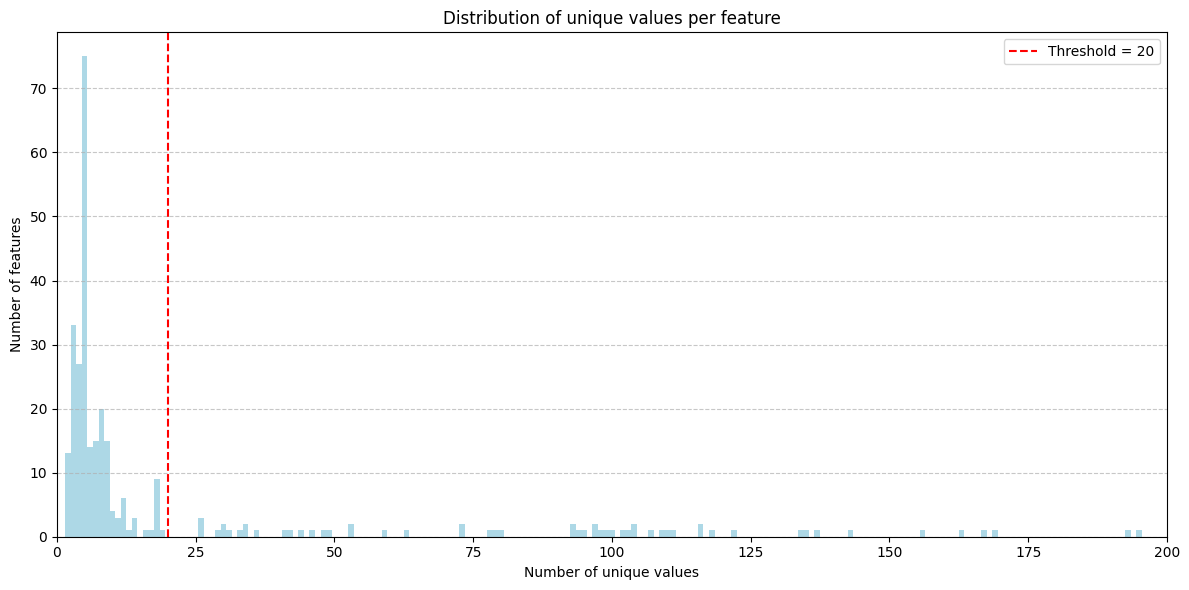

In [4]:
# Fixed threshold
threshold = 20
print(f"Threshold fixed at {threshold} unique values\n")

categorical_idx = []
continuous_idx = []
unique_counts = []

# Compute unique values for every column
for i in range(x_train.shape[1]):
    col = x_train[:, i]
    count = len(np.unique(col))
    unique_counts.append(count)

    if count <= threshold:
        categorical_idx.append(i)
    else:
        continuous_idx.append(i)

# Classifies features as categorical or continuous
print(f"Total categorical features (<= {threshold} unique): {len(categorical_idx)}")
print(f"Total continuous features    (>  {threshold} unique): {len(continuous_idx)}")

# Build histrogram
unique_counts = np.array(unique_counts)
unique_vals, counts = np.unique(unique_counts, return_counts=True)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(unique_vals, counts, color='lightblue', width=1.0)
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Number of unique values')
plt.xlim(right=200)
plt.xlim(left=0)
plt.ylabel('Number of features')
plt.title('Distribution of unique values per feature')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Data cleaning from invalid values and NaN

In [ ]:
### OPTIONAL CELL:
### Try to see if adding this improves performance

### DOESN'T CONVINCE ME THAT 7 CAN BE NON VALID OR VALID DEPENDING ON THE COLUMN / WHETHER FEATURE
### IS CATEGORICAL OR CONTINUOUS, IF I ALWAYS REPLACE IT WITH MEAN WE MIGHT SMOOTH DATA TOO MUCH

# Non valid values to replace
invalid_values = {7, 9, 77, 88, 99, 999, 99900}

# Function to replace non valid values with NaN
def replace_invalids(arr, invalids):
    # Copy array
    arr_clean = arr.copy() 
    for invalid in invalids:
        arr_clean[arr_clean == invalid] = np.nan
    return arr_clean

# Call the function
x_train = replace_invalids(x_train, invalid_values)

In [5]:
missing_counts = np.sum(np.isnan(x_train), axis=0)
missing_percents = missing_counts / x_train.shape[0] * 100

print(f"Number of features with more than 40% of NaN: {np.sum(missing_percents>40)}")

# Drop feature if at least 40% are NaN values
valid_cols_nan = np.where(np.isnan(x_train).sum(axis=0) < 0.4 * x_train.shape[0])[0]
x_train_clean = x_train[:, valid_cols_nan]
x_test_clean = x_test[:, valid_cols_nan]
print(f"Shape after NaN cleaning: {x_train_clean.shape}")

# For other columns, NaN are replaced with the mean
col_mean = np.nanmean(x_train_clean, axis = 0)  # np.nanmean ignores the NaN
inds =np.where(np.isnan(x_train_clean))
x_train_clean[inds] = col_mean[inds[1]]        #x_train_clean[inds] = np.take(col_mean, inds[1])
inds_t =np.where(np.isnan(x_test_clean))
x_test_clean[inds_t] = col_mean[inds_t[1]]

Number of features with more than 40% of NaN: 158
Shape after NaN cleaning: (328135, 163)


Data cleaning: highly correlated features (multicollinearity, e.g. different scales)

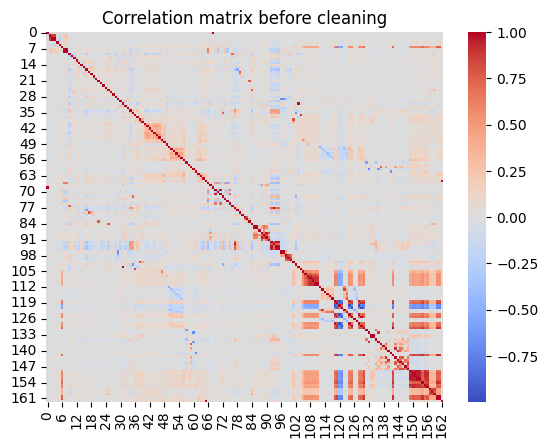

Shape of decorrelated X: (328135, 128)


In [6]:
# Cross-correlation among features
def corrcoef(X):
    n_features = X.shape[1]
    corr = np.empty((n_features, n_features))
    for i in range(n_features):
        for j in range(i, n_features):
            corr_ij = np.corrcoef(X[:, i], X[:, j])[0, 1]       # np.corrcoef returns correlation matrix of two 1D-arrays, corr_ij is in position [0,1]            
            corr[i, j] = corr_ij
            corr[j, i] = corr_ij  
    return corr

corr_matrix = corrcoef(x_train_clean)
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation matrix before cleaning')
plt.show()

# Drop features if correlation > 0.9

non_valid_col = set()  # Use set to avoid duplicates
for i in range(x_train_clean.shape[1]):
    for j in range(i + 1, x_train_clean.shape[1]):
        if abs(corr_matrix[i, j]) > 0.9:
            non_valid_col.add(j)  # Drop j, keep i

x_train_decorr = np.delete(x_train_clean, list(non_valid_col), axis=1)     # Remove column
x_test_decorr = np.delete(x_test_clean, list(non_valid_col), axis=1)
print(f"Shape of decorrelated X: {x_train_decorr.shape}")

Data cleaning: remove low informative features

In [7]:
def drop_low_info_features(X, cont_indices, cat_indices, var_thresh, mode_thresh):
    """
    Removes low-variance features (for continuous variables)
    and high-mode features (for categorical variables),

    """
    
    n_samples = X.shape [0]
    n_features = X.shape [1]
    keep_mask = np.ones(n_features, dtype=bool)
    
    # 1️  continuos feature: variance
    for i in cont_indices:
        var = np.var(X[:, i].astype(float))
        if var < var_thresh:
            keep_mask[i] = False

    # 2️  categorical feature:  mode
    for i in cat_indices:
        col = X[:, i]
        # Find the most frequent value (mode) and its relative frequency, if the latter overcomes a threshold the feaature is dropped since non-informative
        values, counts = np.unique(col, return_counts=True)
        freq_max = counts.max() / n_samples
        if freq_max > mode_thresh:
            keep_mask[i] = False

    # 3️  Filtering valid columns
    X_filtered = X[:, keep_mask]
    
    print(f"Shape after feature removal: {X_filtered.shape}")
    return X_filtered

# Fixed threshold
threshold = 20
categorical_idx = []
continuous_idx = []
unique_counts = []

# Compute unique values for every column
for i in range(x_train_decorr.shape[1]):
    col = x_train_decorr[:, i]
    count = len(np.unique(col))
    unique_counts.append(count)

    if count <= threshold:
        categorical_idx.append(i)
    else:
        continuous_idx.append(i)

x_train_inf= drop_low_info_features(x_train_decorr, cont_indices=continuous_idx, cat_indices=categorical_idx, var_thresh=1e-3, mode_thresh=0.95)
x_test_inf= drop_low_info_features(x_test_decorr, cont_indices=continuous_idx, cat_indices=categorical_idx, var_thresh=1e-3, mode_thresh=0.95)

Shape after feature removal: (328135, 122)
Shape after feature removal: (109379, 122)


Correlation with output

In [8]:
correlations = np.empty(x_train_inf.shape[1])

for i in range(x_train_inf.shape[1]):
    correlations[i] = np.corrcoef(x_train_inf[:, i], y_train)[0, 1]
    
valid_features=np.where(np.abs(correlations)>=0.05)[0]
x_train_denoised=x_train_inf[:,valid_features]
x_test_denoised=x_test_inf[:,valid_features]

print(f"Shape after denoising: {x_train_denoised.shape}")

Shape after denoising: (328135, 46)


Check linearly dependent features

In [9]:
rank = np.linalg.matrix_rank(x_train_denoised)

print(f"Number of features: {x_train_denoised.shape[1]}")
print(f"Rank of the matrix: {rank}")

if rank < x_train_denoised.shape[1]:
    print("Some features are linearly dependent!")


Number of features: 46
Rank of the matrix: 46


Z-score normalization

In [10]:
col_mean_0=np.mean(x_train_denoised, axis=0)
col_sd_0=np.std(x_train_denoised, axis=0)

x_train_norm = (x_train_denoised-col_mean_0) / col_sd_0
x_test_norm = (x_test_denoised - col_mean_0) / col_sd_0

col_mean=np.mean(x_train_norm, axis=0)
col_sd=np.std(x_train_norm, axis=0)

print(f"Before normalization, mean: {col_mean_0[0:5]}, sd: {col_sd_0[0:5]}")
print(f"After normalization, mean: {col_mean[0:5]}, sd: {col_sd[0:5]}")

Before normalization, mean: [2.01500520e+09 2.57200891e+00 6.07248136e+01 1.57375341e+00
 2.21214809e+00], sd: [4.11846911e+03 1.11466944e+00 3.70522863e+01 1.24516539e+00
 1.03262155e+00]
After normalization, mean: [-2.12228099e-11 -2.64024220e-16 -1.20214754e-16 -4.56465810e-17
  2.62013107e-16], sd: [1. 1. 1. 1. 1.]


Classes distribution

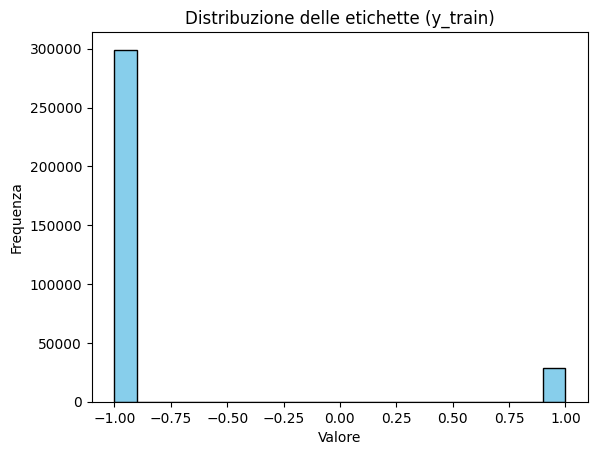

In [11]:
plt.hist(y_train, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribuzione delle etichette (y_train)")
plt.xlabel("Valore")
plt.ylabel("Frequenza")
plt.show()

Split training and validation set

In [12]:
def train_val_split(x, y, val_ratio=0.2, seed=42):
    np.random.seed(seed)
    n_samples = x.shape[0]
    indices = np.random.permutation(n_samples)
    
    split_idx = int(n_samples * (1 - val_ratio))
    train_idx = indices[:split_idx]
    val_idx = indices[split_idx:]
    
    return x[train_idx], y[train_idx], x[val_idx], y[val_idx]

Subsampling of majority class

In [13]:
def subsample_class(x, y, majority_class=-1, target_ratio=1.0, seed=42):
    np.random.seed(seed)
    majority_mask = (y == majority_class)
    minority_mask = ~majority_mask

    x_majority = x[majority_mask]
    y_majority = y[majority_mask]
    x_minority = x[minority_mask]
    y_minority = y[minority_mask]
    
    n_minority = x_minority.shape[0]
    n_majority_sample = int(n_minority * target_ratio)

    indices = np.random.choice(x_majority.shape[0], n_majority_sample, replace=False) # selection with no repetition
    
    x_majority_sampled = x_majority[indices]
    y_majority_sampled = y_majority[indices]
    
    x_balanced = np.vstack((x_majority_sampled, x_minority))
    y_balanced = np.concatenate((y_majority_sampled, y_minority))
    
    # Shuffle on x and y
    perm = np.random.permutation(x_balanced.shape[0])
    return x_balanced[perm], y_balanced[perm]


Logistic regression

In [14]:
# Split
X_train, y_train, X_val, y_val = train_val_split(x_train_norm, y_train, val_ratio=0.2)

# Subsampling
X_bal, y_bal = subsample_class(X_train, y_train, target_ratio=1.0)


In [16]:
k_fold=5
k_indices=build_k_indices(y_bal, k_fold, seed=42)
loss_val=[]
loss_tr=[]
ws=[]
initial_w = np.zeros((X_bal.shape[1], 1))

for k in range(k_fold):
    w, loss_tr_tmp=cross_validation(y_bal, X_bal, k_indices, k, initial_w, max_iters=1000, gamma=0.1)
    loss_tr.append(loss_tr_tmp)
    ws.append(w)
    loss_val_tmp=logistic_loss(y_val, X_val, w)
    loss_val.append(loss_val_tmp)
    
w_best=np.mean(ws, axis=0)

MemoryError: Unable to allocate 10.2 GiB for an array with shape (36920, 36920) and data type float64

In [ ]:
#w_best = np.mean(np.stack(ws, axis=0), axis=0)  # mantiene la shape (D, 1)
y_pred_prob = sigmoid(x_test_norm @ w_best)
y_pred = np.where(y_pred_prob >= 0.5, 1, -1)

create_csv_submission(test_ids, y_pred, 'Logistic_2')